# Linear regression with NumPy

In this notebook, we will implement a linear regressor for the diabete disease problem. we will predict house prices training the predictor on previous collected data.

The idea behind (multiple) linear regression is to extract a linear relation between features and target data which can be represented by the following equation:
$$
y(x_1, x_2, \dots, x_n) = \theta_0 + \theta_1x_1 + \theta_2x_2+\dots + \theta_n x_n = \theta_0 + \sum_{i=1}^n \theta_i\cdot x_i ~~~~~~~~~~~~~~~~~~~~~~~~(1)
$$

In [1]:
# Import packages for data loading/manipulation
import numpy as np
import matplotlib.pyplot as plt

# Dataset and utils
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

# Additional packages
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from mpl_toolkits import mplot3d

**Dataset loading**

The Diabetes dataset contains a quantitative measure of disease progression one year after baseline depending on several parameters. The dataset contains 442 samples and 10 features. We will fit a linear model and predict disease progression using unseen data after splitting the dataset into training (80%) and test (20%) set. The target variable is represented by the "TARGET" feature.

In [2]:
# Load dataset
dataset = load_diabetes()
print("Dataset loaded!")

Dataset loaded!


In [3]:
print(dataset.keys())

dict_keys(['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename', 'data_module'])


In [4]:
print(dataset.data)
print(f"\nThe dataset contains {dataset.data.shape[0]} samples and {dataset.data.shape[1]} features")

[[ 0.03807591  0.05068012  0.06169621 ... -0.00259226  0.01990749
  -0.01764613]
 [-0.00188202 -0.04464164 -0.05147406 ... -0.03949338 -0.06833155
  -0.09220405]
 [ 0.08529891  0.05068012  0.04445121 ... -0.00259226  0.00286131
  -0.02593034]
 ...
 [ 0.04170844  0.05068012 -0.01590626 ... -0.01107952 -0.04688253
   0.01549073]
 [-0.04547248 -0.04464164  0.03906215 ...  0.02655962  0.04452873
  -0.02593034]
 [-0.04547248 -0.04464164 -0.0730303  ... -0.03949338 -0.00422151
   0.00306441]]

The dataset contains 442 samples and 10 features


In [5]:
print("Feature names:\n")
print(dataset.feature_names)

Feature names:

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']


In [6]:
print(dataset.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

**Data analysis**

Before training a linear regressor, we will visualize the relationship between each feature and target data with histograms and scatter plots using the matplotlib library.

Let’s first plot the distribution of the target variable.

In [7]:
X = np.array(dataset.data) # Features
y = np.array(dataset.target) # Prices

print(f"X shape: {X.shape}. Target variable: {y.shape}")

X shape: (442, 10). Target variable: (442,)


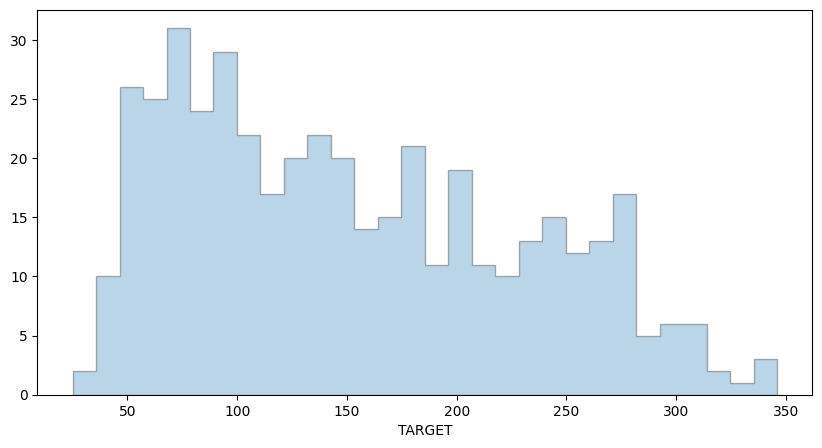

In [8]:
plt.figure(figsize=(10, 5))
kwargs = dict(histtype='stepfilled', alpha=0.3, density=False, bins=30, ec="k")
plt.hist(y, **kwargs)
plt.xlabel("TARGET")
plt.show()

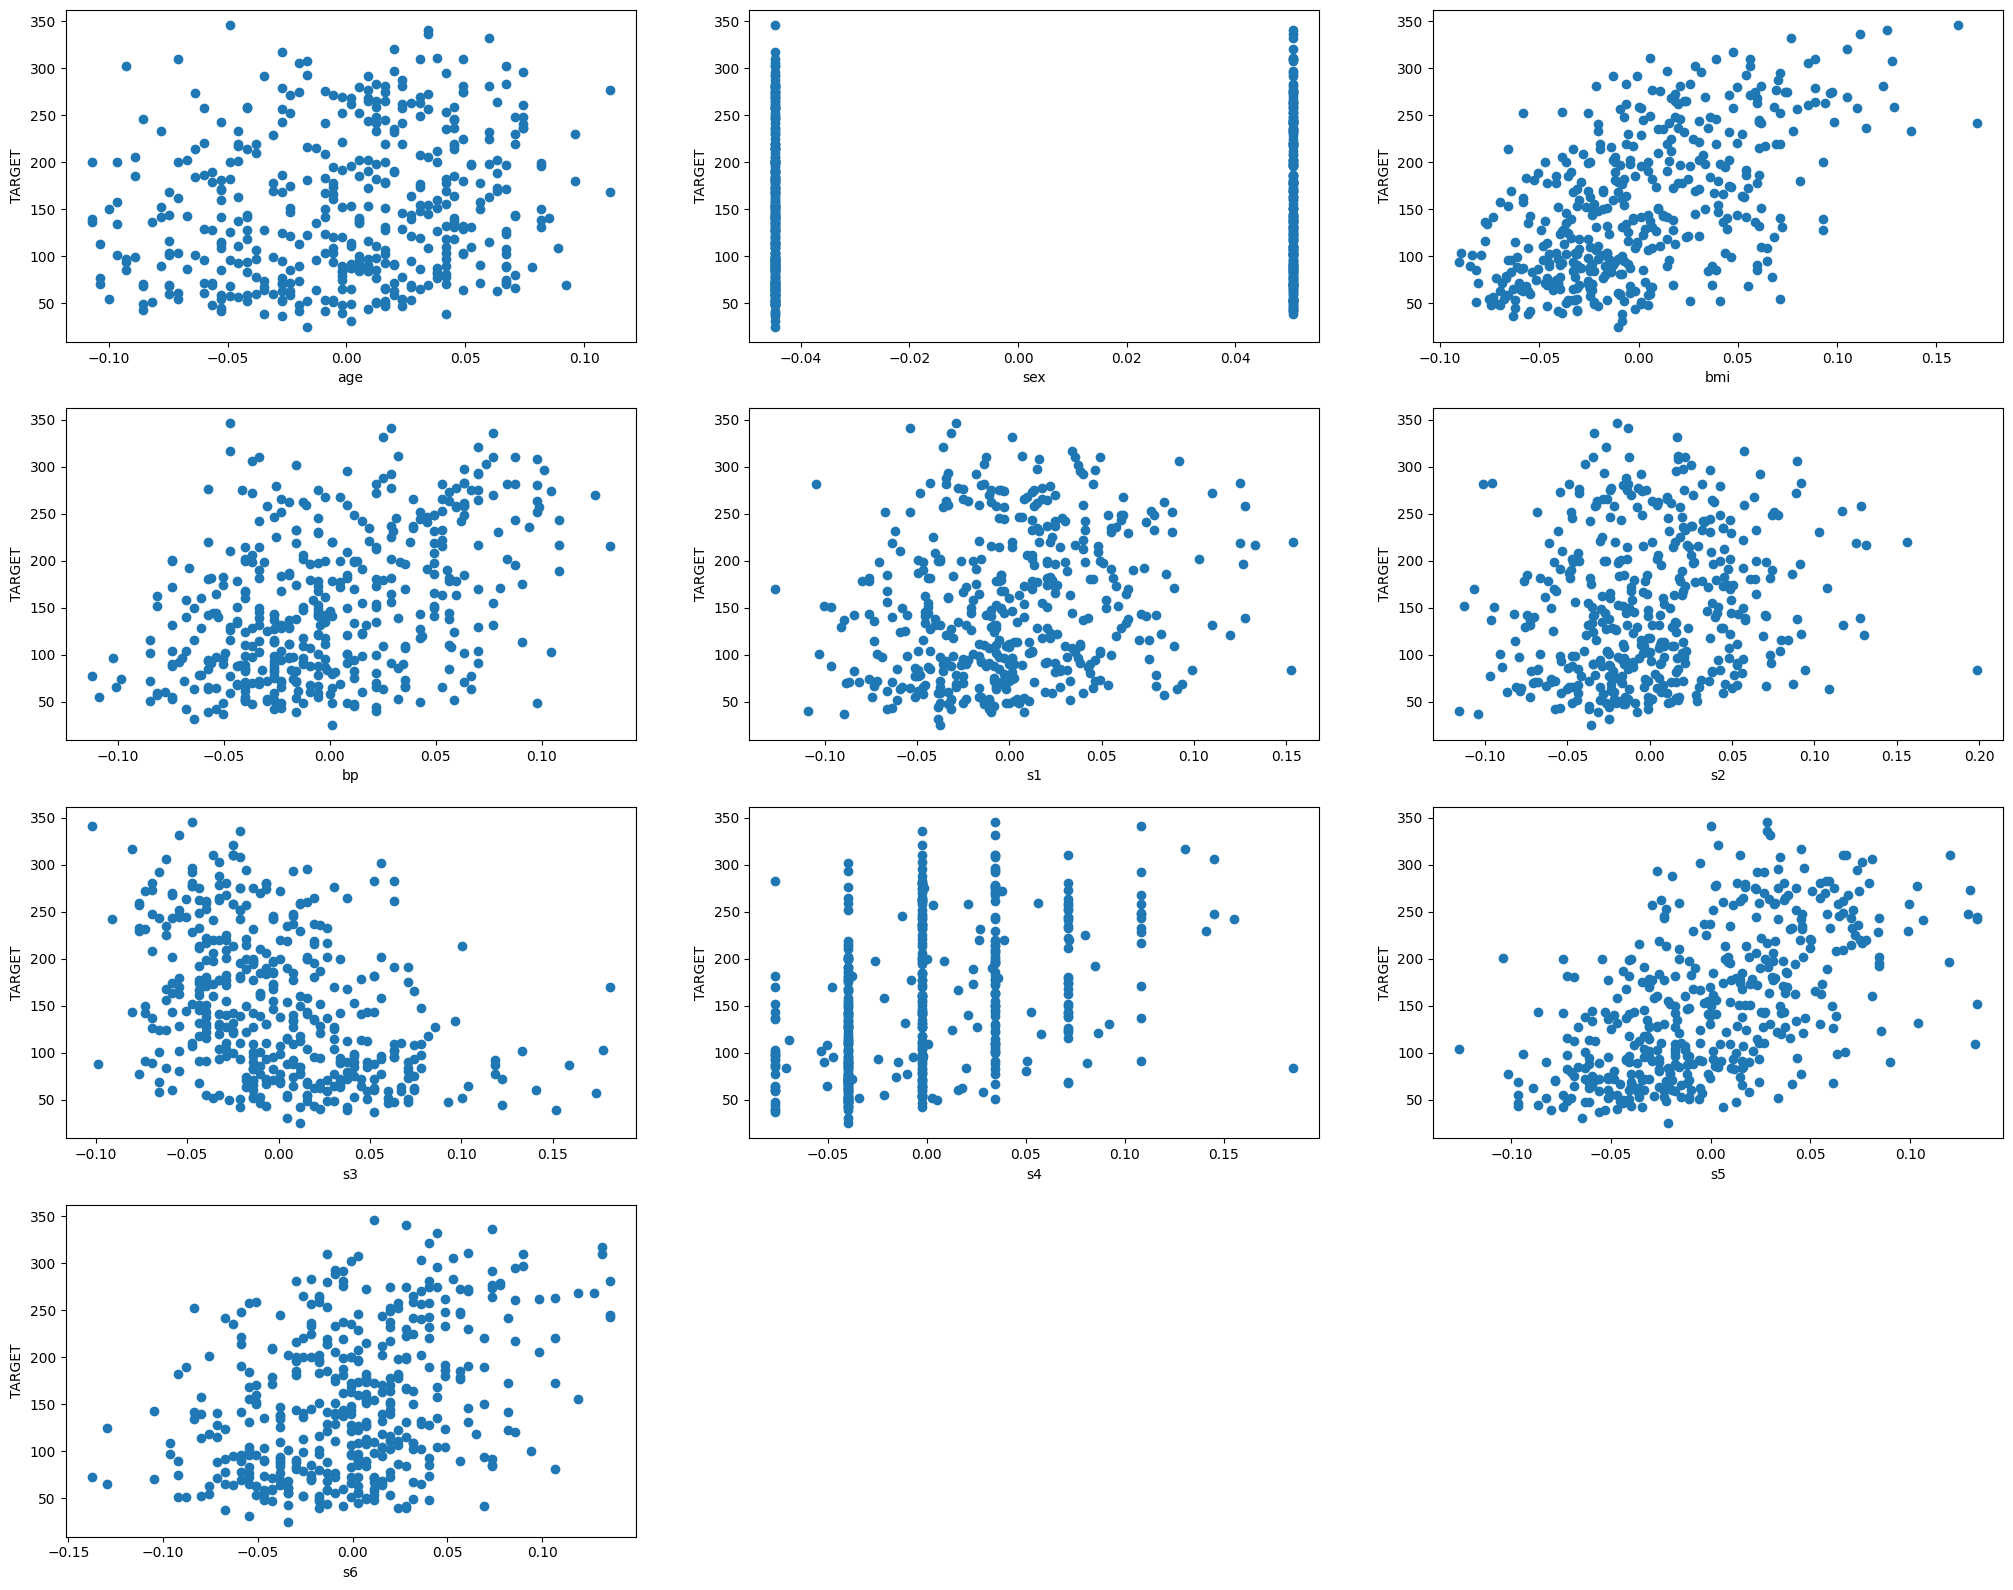

In [9]:
features = dataset.feature_names
plt.figure(figsize=(25, 25))

for i, feature in enumerate(features):
  plt.subplot(5, 3 , i+1)
  # Select i-th feature
  x = X[:, i]
  # Scatter plot
  plt.scatter(x, y, marker='o')
  plt.xlabel(feature)
  plt.ylabel('TARGET')

# Simple linear regression

In simple linear regression, a single independent variable is used to predict the value of a dependent variable. Since it is hard to *visualize* our model with multiple features, we will first predict the house prices with just one variable and then move to the regression with all the features.
For example, we can select the bmi feature which shows a negative correlation with the house prices.

$$
y(x) = \theta_0 + \theta_1x
$$

In [10]:
# Select BMI feature from X
X_bmi = X[:, 2].reshape(-1,1)
y_target = y.reshape(-1,1)

print(X_bmi.shape)
print(y_target.shape)

(442, 1)
(442, 1)


In [11]:
# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(\
                X_bmi, y_target, test_size=0.2, random_state=5)

The objective of linear regression is to minimize the cost function

$$
J(\theta_0, ..., \theta_n) = \frac{1}{2m}\sum_{i = 1}^{m} (h_{\theta}(x^{(i)})-y^{(i)})^2 ~~~~~~~~~~~~~~~~~~~(2)
$$
where the hypothesis $h_{\theta}(x)$ is given by the linear model

$$
h_{\theta}(x) = {\theta}^Tx = \theta_0 + \theta_1x_1 + ... + \theta_nx_n. ~~~~~~~~~~~~~~~~~~~~~~~~(3)
$$

In each iteration, we perform the following update:

$$
\theta_j := \theta_j-\alpha\frac{1}{m}\sum_{i = 1}^{m}(h_{\theta}(x^{(i)})-y^{(i)})x_j^{(i)} ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~(4)
$$

Firstly, we will implement our cost function $J(\theta)$ and then the gradient descent algorithm.

In [12]:
# Loss function - Sum of Squared Errors (SSE)

def compute_cost(X, y, theta):
  """
  Compute cost function as reported in Eq. (2)

  Input parameters
  ----------------
  X: np.array [num_samples x (num_features + 1)]
  y: np.array [num_samples x 1]
  theta: np.array [(num_features + 1) x 1]

  Output parameters
  -----------------
  J: float [1 x 1]

  """

  J = np.sum(np.square(np.dot(X, theta) - y)) / (2 * X.shape[0])
  # J = np.sum(np.power(np.sum((np.transpose(theta) * X),1).reshape(-1,1) - y, 2))/(2*X.shape[0])

  return J

In [13]:
# Check compute_cost function output
np.random.seed(1)
J = compute_cost(np.random.randint(1, 100, (50, 2)), np.random.randint(1, 50, (50, 1)), np.array([[0], [0]]))
print(J)

317.34


Implement the gradient descent algorithm for simple linear regression, as reported in Equation (4), using the following steps:

Repeat until convergence (or maximum number of iterations) {
  1. Update each theta using Eq. (4);
  2. Compute cost
  
}


In [14]:
def gradient_descent(X, y, theta, learning_rate, num_iters):
  """
  Gradient descent algorithm

  Input parameters
  ----------------
  X: np.array [num_samples x (num_features + 1)]
  y: np.array [num_samples x 1]
  theta: np.array [(num_features + 1) x 1]
  learning_rate: int [1 x 1]
  num_iter: int [1 x 1]

  Output parameters
  -----------------
  theta: np.array [(num_features + 1) x 1]
  theta_history: np.array [(num_features + 1) x num_iters]
  J_history: int [num_iters x 1]
  """

  num_samples = X.shape[0]
  J_history = np.zeros((num_iters, 1))
  theta_history = np.zeros((theta.shape[0], num_iters))
  temp_theta = theta
  for i in range(num_iters):
    for j in range(theta.shape[0]):
      temp_theta[j, 0] = temp_theta[j, 0] - learning_rate / num_samples * np.sum((np.dot(X,theta) - y) * X[:, j].reshape(-1, 1))
    theta = temp_theta
    theta_history[:, i] = theta[:, 0]
    J_history[i] = compute_cost(X, y, theta)
  return (theta, theta_history, J_history)

In [15]:
# Check gradient_descent function output
np.random.seed(2)
theta, theta_history, J_history = \
      gradient_descent(np.random.randint(1, 50, (25, 2)),
                       np.random.randint(1, 25, (25, 1)),
                       np.array([[0], [0]]),
                       0.005, 4)
print(f"Theta: {theta}, \ntheta_history: {theta_history}, \nJ_history: {J_history}")

Theta: [[-15]
 [-12]], 
theta_history: [[  1.   0. -10. -15.]
 [ -1.   4.  18. -12.]], 
J_history: [[   380.7 ]
 [  5859.32]
 [ 77062.12]
 [292115.72]]


In [16]:
# Add intercept term to X_train
print(f"X_train shape: {X_train.shape} (without intercept term)")
X_train = np.hstack((np.ones((X_train.shape[0],1)), X_train))
print(f"X_train shape: {X_train.shape} (with intercept term)")

X_train shape: (353, 1) (without intercept term)
X_train shape: (353, 2) (with intercept term)


In [17]:
# Define and initialize parameters
theta = np.zeros((X_train.shape[1], 1))
print(f"{theta}")

[[0.]
 [0.]]


In [18]:
num_iters = 3000
learning_rate = 0.7
initial_cost = compute_cost(X_train, y_train, theta)
print("J (initial): ", initial_cost, "\n")

J (initial):  14263.645892351275 



In [19]:
# Apply gradient descent algorithm
(theta, theta_history, J_history) = gradient_descent(X_train, y_train, theta, learning_rate, num_iters)
print(f"Optimal parameters: [{theta[0]}, {theta[1]}]")
print(f"J (final): {J_history[-1]}")

Optimal parameters: [[151.79941525], [931.68806349]]
J (final): [1882.31435889]


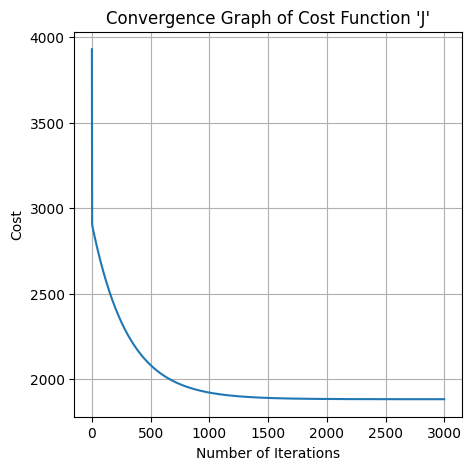

In [20]:
# Plot J history
plt.figure(figsize=(5, 5))
plt.plot(range(len(J_history)), J_history)
plt.title("Convergence Graph of Cost Function 'J'")
plt.xlabel("Number of Iterations")
plt.ylabel("Cost")
plt.grid()
plt.show()

* Plot fitted model

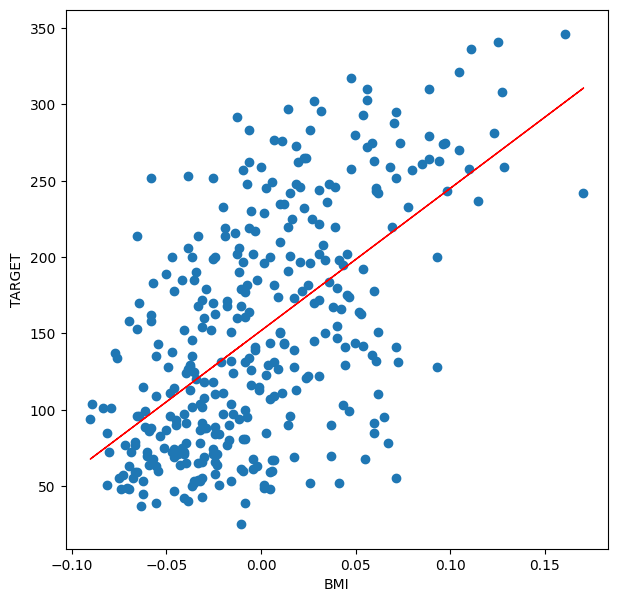

In [21]:
plt.figure(figsize=(7, 7))
plt.scatter(X_train[:,1], y_train)

# Predict values from training data
out = theta[0] + X_train[:,1] * theta[1]

plt.plot(X_train[:,1], out, 'r-', linewidth = 1)
plt.ylabel('TARGET')
plt.xlabel('BMI')
plt.show()

# $J(\theta_0, \theta_1)$ Visualization

To better understand the cost function, let's plot the cost over a 2-dimensional grid of $\theta_0$ and $\theta_1$ values.

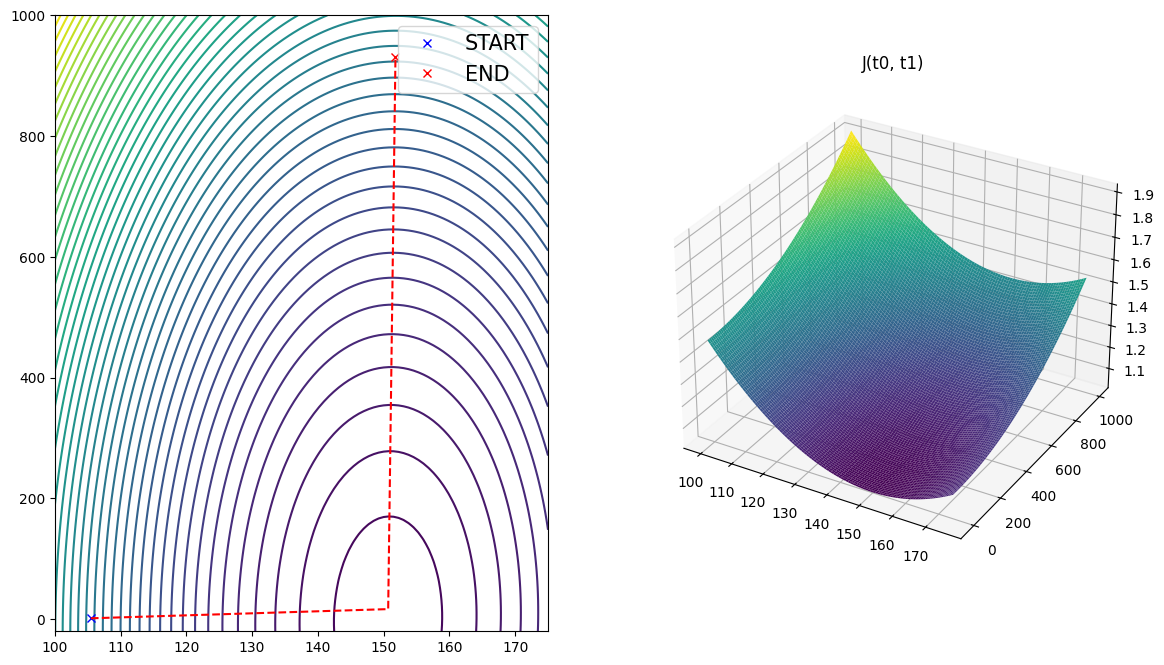

In [22]:
fig = plt.figure(figsize=(14,8)) # create the canvas for plotting
ax1 = fig.add_subplot(1,2,1)

# Create grid of theta_0/theta_1 values
theta0_values = np.linspace(100, 175, 100);
theta1_values = np.linspace(-20, 1000, 100);
T0, T1 = np.meshgrid(theta0_values, theta1_values)
J = np.zeros((theta0_values.shape[0] * theta1_values.shape[0]))

# Compute cost function for each point in the grid
for i, (t0,t1) in enumerate(zip(T0.reshape(-1), T1.reshape(-1))):
  theta = [t0, t1]
  J[i] = compute_cost(X_train, y_train, theta)

J = J.reshape(theta0_values.shape[0], theta1_values.shape[0])

# Plot cost function
plt.contour(T0, T1, J, 50)

# Plot theta history
plt.plot(theta_history[0, 0], theta_history[1, 0], 'bx', # INITIAL POSITION
         theta_history[0, -1], theta_history[1, -1], 'rx', # FINAL POSITION
         theta_history[0, ::10], theta_history[1, ::10], 'r--')
plt.legend(['START', 'END'], fontsize=15)
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(T0, T1, J, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax2.set_title('J(t0, t1)')
plt.show()

# Multiple Linear Regression
Features in a dataset may differ by orders of magnitude. To perform multiple linear regression we will firstly apply a *feature scaling* technique to make the gradient descent algorithm to converge much more quickly.

We will consider a normalization technique called *Standardization*:

$$
z = \frac{x - \mu}{\sigma}~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~(5)
$$
where
$$
\mu = \frac{1}{m}\sum_{i=1}^m x_i,~~~\sigma = \sqrt{\frac{1}{m}\sum_{i=1}^m (x_i-\mu)^2}. ~~~~~~~~~~~~~~~~~~~(6)
$$

In [23]:
# Use all features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
# Compute training set mean
mu = np.mean(X_train, axis = 0)
# Compute training set standard deviation
sigma = np.std(X_train, axis = 0)

# Normalize training set
X_train_norm = (X_train - mu) / sigma
y_train = y_train.reshape(-1, 1)
print(f"X_train shape: {X_train_norm.shape}\ny_train shape: {y_train.shape}")

X_train shape: (353, 10)
y_train shape: (353, 1)


**Implementation detail**: For the multivariate case, we need to consider the vectorized form of the cost function:

$$
J(\theta) = \frac{1}{2m}(X\theta-y)^T(X\theta-y) ~~~~~~~~~~~~~~~~~~~(7)
$$

Now, we can implement the cost function for the multivariate case as reported in Equation (7).

(Note that this function will replace the one defined for simple linear regression.)

In [24]:
# Loss function - Sum of Squared Errors (SSE)
def compute_cost(X, y, theta):
  """
  Compute cost function as reported in Eq. (7)

  Input parameters
  ----------------
  X: np.array [num_samples x (num_features + 1)]
  y: np.array [num_samples x 1]
  theta: np.array [(num_features + 1) x 1]

  Output parameters
  -----------------
  J: float [1 x 1]

  """

  num_samples = X.shape[0]
  J = np.dot(np.transpose((np.dot(X, theta) - y)), np.dot(X, theta) - y) / (2 * num_samples)
  return J

In [25]:
# Check compute_cost function output
np.random.seed(2)
J = compute_cost(np.random.randint(1, 100, (25, 5)),
                       np.random.randint(1, 100, (25, 1)),
                       np.zeros((5,1)))
print(f"J: {J}")

J: [[2101.9]]


In [26]:
# Add intercept term to X_train
X_train_norm = np.hstack((np.ones((X_train_norm.shape[0],1)), X_train_norm))
print(f"X_train_norm shape: {X_train_norm.shape}")

X_train_norm shape: (353, 11)


In [27]:
# Define and initialize theta parameters
theta = np.zeros((X_train_norm.shape[1], 1))
print(f"Theta shape: {theta.shape}")

Theta shape: (11, 1)


In [28]:
# Hyper-parameters
num_iters = 400
learning_rate = 0.01
initial_cost = compute_cost(X_train_norm, y_train, theta)
print("Initial cost is: ", initial_cost, "\n")

Initial cost is:  [[14520.35410765]] 



In [29]:
(theta, _, J_history) = gradient_descent(X_train_norm, y_train, theta, learning_rate, num_iters)
print("Theta: \n", theta, "\n")
print("Final cost is: ", J_history[-1])

Theta: 
 [[148.90985463]
 [  1.99176539]
 [-13.12580586]
 [ 23.59477964]
 [ 17.08347359]
 [ -2.35811391]
 [ -5.50035369]
 [ -9.00209236]
 [  7.10820385]
 [ 21.63940618]
 [  2.5894512 ]] 

Final cost is:  [1453.18393762]


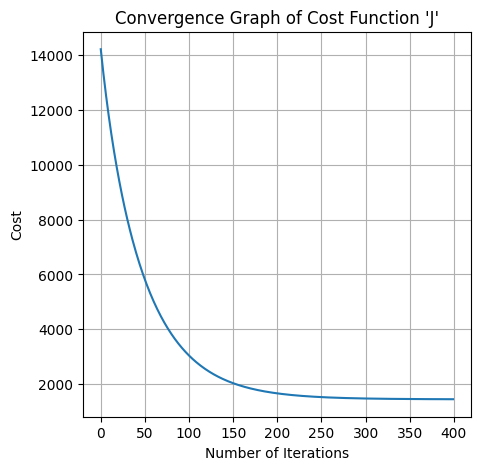

In [30]:
plt.figure(figsize=(5, 5))
plt.plot(range(len(J_history)), J_history)
plt.title("Convergence Graph of Cost Function 'J'")
plt.xlabel("Number of Iterations")
plt.ylabel("Cost")
plt.grid()
plt.show()

In [31]:
# Predict new values
def predict(X, mu, sigma, theta):
  """
  Predict new values

  Input parameters
  ----------------
  X: np.array [num_samples x num_features]
  mu: np.array [num_features x 1]
  sigma: np.array [num_features x 1]
  theta: np.array [(num_features + 1) x 1]

  Output parameters
  -----------------
  y: float [num_samples x 1]

  """
  num_samples = X.shape[0]

  # Normalize input data with mu and sigma computed from the training set
  X_norm = (X - mu) / sigma

  # Compute X*theta
  y = np.dot(np.hstack((np.ones((num_samples, 1)), X_norm)), theta)

  return y

In [32]:
# Predicted prices for the test set
y_pred = predict(X_test, mu, sigma, theta)
print(y_pred.shape)

(89, 1)


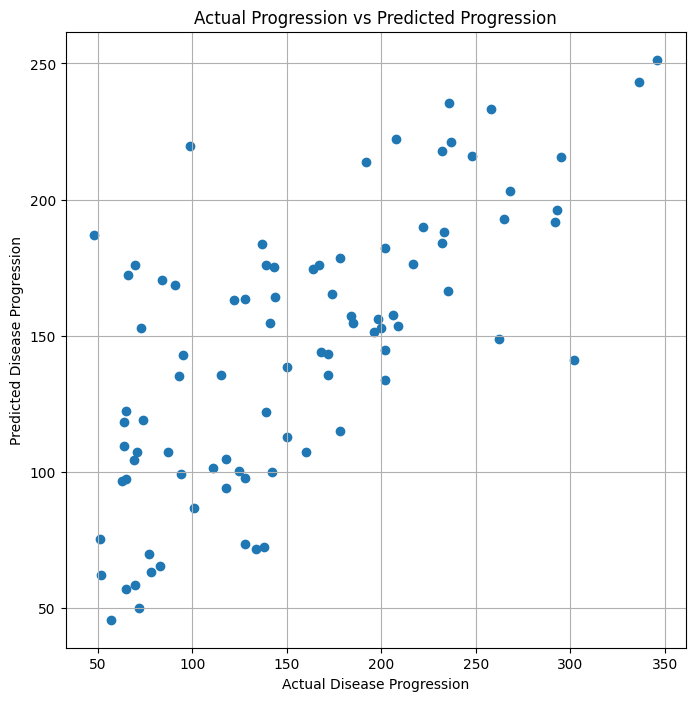

In [33]:
# Plot difference between actual prices and predicted values
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Disease Progression")
plt.ylabel("Predicted Disease Progression")
plt.title("Actual Progression vs Predicted Progression")
plt.grid('on')
plt.show()

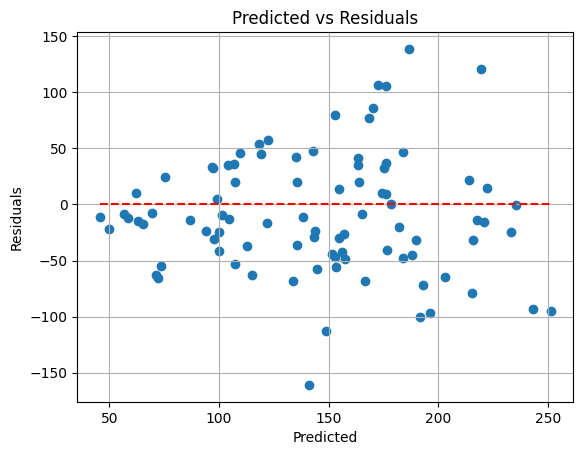

In [34]:
# Plot Residuals
plt.scatter(y_pred, y_pred - y_test.reshape(-1,1))
#The expected error is 0
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), linestyles='dashed', colors='red')
plt.title("Predicted vs Residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.grid('on')
plt.show()

# Performance evaluation

To evaluate the performance of our linear model, we will use the RMSE metric. We will also compare our model to the *Scikit-learn* linear regressor.

In [35]:
sklearn_reg = LinearRegression()
sklearn_reg.fit(X_train, y_train)
# Sklearn linear regressor - TRAIN
y_train_pred_skl = sklearn_reg.predict(X_train)
# Sklearn linear regressor - TEST
y_test_pred_skl = sklearn_reg.predict(X_test)
# RMSE sklearn regressor
rmse_skl_train = (np.sqrt(mean_squared_error(y_train, y_train_pred_skl)))
rmse_skl_test = (np.sqrt(mean_squared_error(y_test, y_test_pred_skl)))

# Our regressor - TRAIN
y_train_pred_our = predict(X_train, mu, sigma, theta)
# RMSE ours
rmse_our_train = (np.sqrt(mean_squared_error(y_train, y_train_pred_our)))
rmse_our_test = (np.sqrt(mean_squared_error(y_test, y_pred)))

print("Model performance (RMSE)")
print("------------------------")
print("\t Sklearn \t Ours")
print('Train \t {:.3f} \t\t {:.3f}'.format(rmse_skl_train, rmse_our_train))
print('Test \t {:.3f} \t\t {:.3f}'.format(rmse_skl_test, rmse_our_test))

Model performance (RMSE)
------------------------
	 Sklearn 	 Ours
Train 	 53.506 		 53.911
Test 	 54.216 		 54.142


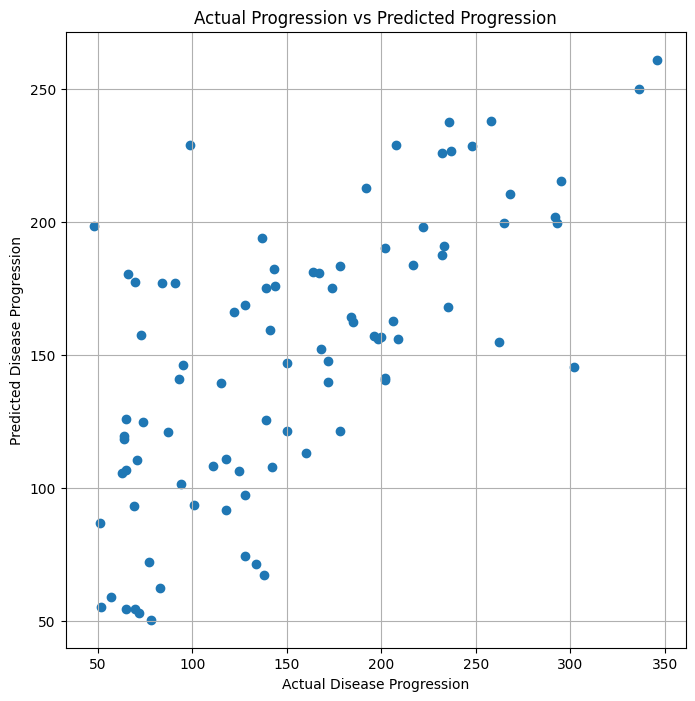

In [36]:
# Plot difference between actual prices and predicted values (Sklearn)
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_test_pred_skl)
plt.xlabel("Actual Disease Progression")
plt.ylabel("Predicted Disease Progression")
plt.title("Actual Progression vs Predicted Progression")
plt.grid('on')
plt.show()

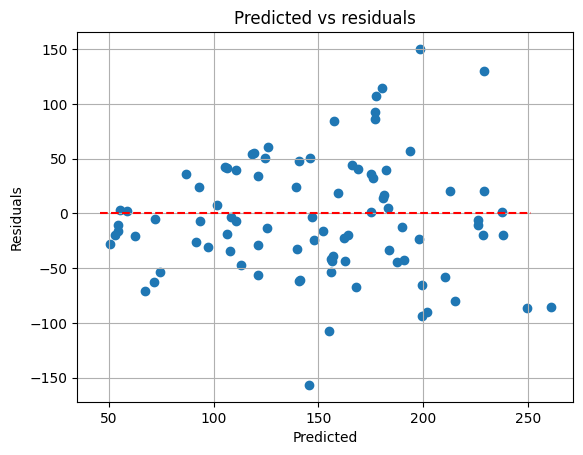

In [37]:
# Plot Residuals (Sklearn)
plt.scatter(y_test_pred_skl, y_test_pred_skl - y_test.reshape(-1,1))
#The expected error is 0
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), linestyles='dashed', colors='red')
plt.title("Predicted vs residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.grid('on')
plt.show()

Linear regression problems can also be solved (in one step) in closed-form using the following formula:

$\theta = (X^T X)^{-1}X^Ty$.

Such formula does not require any feature scaling but you still need to add a column of 1’s to the $X$ matrix to have an intercept term.

In [38]:
def normalEqn(X, y):
  """
  Computes the closed-form solution to linear regression using the normal equations.

  Input parameters
  ----------------
  X: np.array [num_samples x num_features]
  y: np.array [num_samples x 1]

  Output parameters
  -----------------
  theta: np.array [(num_features + 1) x 1]
  """

  theta = np.linalg.pinv(np.dot(np.transpose(X),X)).dot(np.transpose(X)).dot(y)
  return theta

In [39]:
# Check normalEqn function output
np.random.seed(1)
theta_check = normalEqn(np.random.randint(1, 100, (50, 2)), np.random.randint(1, 50, (50, 1)))
print(theta_check)

[[0.20798672]
 [0.16799718]]


In [40]:
theta_ne = normalEqn(np.hstack((np.ones((X_train.shape[0],1)), X_train)), y_train)
print(theta_ne.shape)

(11, 1)


In [41]:
y_pred_ne = np.dot(np.hstack((np.ones((X_test.shape[0], 1)), X_test)), theta_ne)

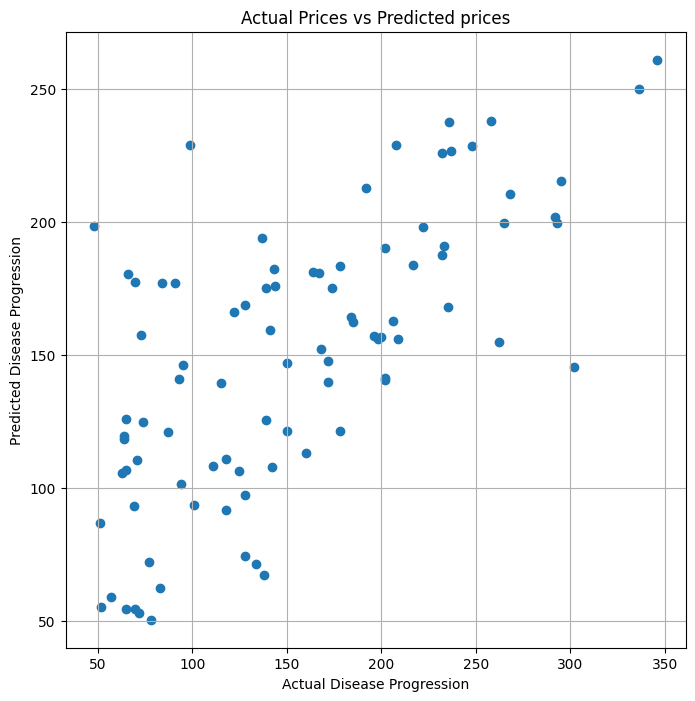

In [42]:
# Plot difference between actual prices and predicted values
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_ne)
plt.xlabel("Actual Disease Progression")
plt.ylabel("Predicted Disease Progression")
plt.title("Actual Prices vs Predicted prices")
plt.grid('on')
plt.show()

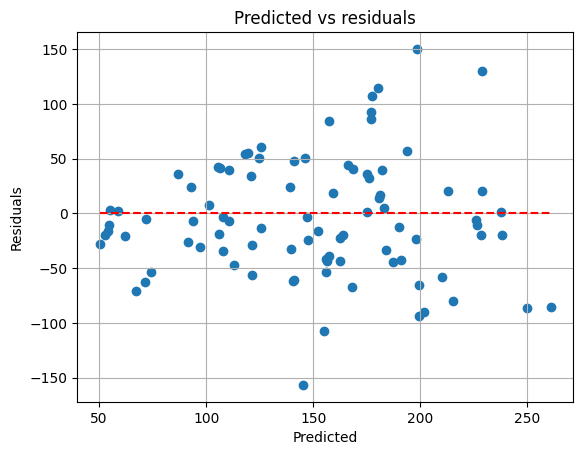

In [43]:
# Plot Residuals
plt.scatter(y_pred_ne, y_pred_ne - y_test.reshape(-1,1))
#The expected error is 0
plt.hlines(y=0, xmin=y_pred_ne.min(), xmax=y_pred_ne.max(), linestyles='dashed', colors='red')
plt.title("Predicted vs residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.grid('on')
plt.show()

In [44]:
# RMSE Normal Equation
y_pred_ne_train = np.dot(np.hstack((np.ones((X_train.shape[0], 1)), X_train)), theta_ne)
rmse_ne_train = (np.sqrt(mean_squared_error(y_train, y_pred_ne_train)))
rmse_ne_test = (np.sqrt(mean_squared_error(y_test, y_pred_ne)))

print("Model performance (RMSE)")
print("------------------------")
print("\t Normal Equation")
print('Train \t     {:.3f}'.format(rmse_ne_train))
print('Test  \t     {:.3f}'.format(rmse_ne_test))

Model performance (RMSE)
------------------------
	 Normal Equation
Train 	     53.506
Test  	     54.216
